In [1]:
import pandas as pd
import numpy as np
import tqdm as td
import datetime
from sklearn import preprocessing
from sklearn.decomposition import PCA
from  prince import  FAMD


In [2]:
import findspark
findspark.init()
import pyspark

### 2. Grouping customers together!

Now we will deal with clustering algorithms that will provide groups of clients which are similar among them.

#### 2.1 Getting your data + feature engineering

In [3]:
df = pd.read_csv('bank_transactions.csv')
df.dropna(inplace=True)

In [4]:
USD=df['TransactionAmount (INR)'].apply(lambda x:round(x/81.67,2))
df['TransactionAmount_USD']=USD
USD_2=df['CustAccountBalance'].apply(lambda x:round(x/81.67,2))
df['CustAccountBalance_USD']=USD_2
new_df=df.rename(columns={'TransactionAmount (INR)':'TransactionAmount'})
new_df.CustomerDOB = pd.to_datetime(new_df.CustomerDOB) 

In [5]:
new_df.drop(new_df[new_df.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)
new_df.TransactionDate=pd.to_datetime(new_df.TransactionDate) 

In [6]:
new_df.TransactionTime = new_df.TransactionTime.apply(lambda x: datetime.datetime.strptime(str(x).zfill(6), '%H%M%S'))

In [7]:
new_df.loc[new_df.CustomerDOB.dt.year > 2000, 'CustomerDOB']=new_df.loc[new_df.CustomerDOB.dt.year > 2000, 'CustomerDOB']-pd.DateOffset(years = 100)

In [8]:
new_df['CustomerAge'] = (( pd.to_datetime('today') - new_df.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0).astype(int)

In [9]:
dataset=pd.DataFrame()
dataset['CustomerID']=new_df.CustomerID.unique()
dataset=dataset.set_index('CustomerID')

In [10]:
#Number of transactions
new_df.groupby(['CustomerID'],sort=False)['TransactionID'].count()
dataset['Number_Transactions']=new_df.groupby(['CustomerID'],sort=False).count()['TransactionID']

In [11]:
#Number of transactions with a balance bigger than 100 USD
def condition(x):
    if x>100:
        return int(1)
    else:
        return 0

new_df['TransactionAmount_USD>100']=new_df['TransactionAmount_USD'].apply((condition)).to_numpy()
a=new_df.groupby('CustomerID',sort=False)['TransactionAmount_USD>100'].sum()
dataset['Transactions>100']=a

In [12]:
# Average amount of the transactions on USD column
new_df.groupby('CustomerID',sort=False)['TransactionAmount_USD'].mean()
dataset['AverageAmountTransactions']=new_df.groupby('CustomerID',sort=False)['TransactionAmount_USD'].mean().to_numpy()

In [13]:
#Average balance in USD exchange rate 1 USD = 81,67 INR
new_df.groupby(['CustomerID'],sort=False)['CustAccountBalance_USD'].mean()
dataset['AverageBalance']=new_df.groupby(['CustomerID'],sort=False)['CustAccountBalance_USD'].mean()

In [14]:
#Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation)
dataset['Utilisation']=dataset.iloc[:,[-1]].to_numpy()-dataset.iloc[:,[-2]].to_numpy()

In [15]:
# Most common gender of the customer
dataset['MostCommonGender']=new_df.groupby('CustomerID',sort=False)['CustGender'].agg(pd.Series.mode)
dataset['MostCommonGender']=dataset.MostCommonGender.apply(lambda x : x[0] if isinstance(x,np.ndarray) else x)

In [16]:
# Most frequent location of the customer
dataset['MostCommonLocation']=new_df.groupby('CustomerID',sort=False)['CustLocation'].agg((pd.Series.mode))
dataset['MostCommonLocation']=dataset.MostCommonLocation.apply(lambda x : x[0] if isinstance(x,np.ndarray) else x)

Consider at least 20 additional features that can be generated for each CustomerId. Describe each of them and why you believe they will be helpful. 
 Moreover, add it to the previous dataset (the one with seven features). In the end, you should have for each CustomerID at least 27 features (7 recommended + 20 suggested by you).

In [17]:
new_df

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,TransactionAmount_USD,CustAccountBalance_USD,CustomerAge,TransactionAmount_USD>100
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,0.31,218.18,28,0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,342.83,27.80,66,1
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,5.62,218.86,26,0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,1900-01-01 14:27:14,2060.0,25.22,10609.81,49,0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5,21.58,82.21,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,1900-01-01 18:48:24,799.0,9.78,93.49,32,0
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,1900-01-01 18:37:34,460.0,5.63,334.41,31,0
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,1900-01-01 18:33:13,770.0,9.43,2715.28,34,0
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,1900-01-01 18:47:06,1000.0,12.24,123.89,44,0


In [19]:
## average transactions and balance in INR
dataset['AverageTransaction(INR)']=new_df.groupby('CustomerID')['TransactionAmount'].mean()
dataset['AverageBalance(INR)']=new_df.groupby('CustomerID')['CustAccountBalance'].mean()

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilisation,MostCommonGender,MostCommonLocation,AverageTransaction(INR),AverageBalance(INR)
CustomerID,,,,,,,,,
C5841053,1,0,0.31,218.18,217.87,F,JAMSHEDPUR,25.0,17819.050
C2142763,1,1,342.83,27.80,-315.03,M,JHAJJAR,27999.0,2270.690
C4417068,1,0,5.62,218.86,213.24,F,MUMBAI,459.0,17874.440
C5342380,2,0,17.99,5324.47,5306.48,F,MUMBAI,1469.2,434849.495
C9031234,1,0,21.58,82.21,60.63,F,NAVI MUMBAI,1762.5,6714.430
...,...,...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,-31.04,M,PUNE,3000.0,464.870
C1034220,1,0,18.37,14.85,-3.52,M,BANGALORE,1500.0,1212.700
C8020229,1,0,9.78,93.49,83.71,M,NEW DELHI,799.0,7635.190


In [20]:
dataset['%trans/balance']=(dataset.AverageAmountTransactions/dataset.AverageBalance).apply(lambda  x:round(x*100,2))

In [21]:
## average of time of transactions for each customers
dataset['AverageHourTransaction'] = new_df.groupby('CustomerID',sort=False)['TransactionTime'].mean().apply(lambda x: x.hour)

In [22]:
dataset['AverageDaysBetweenTransactions'] = new_df.groupby('CustomerID', sort=False)['TransactionDate'].agg(lambda x: x.dt.date)

dataset['AverageDaysBetweenTransactions'] = dataset.AverageDaysBetweenTransactions.apply(lambda x: np.sort(x) if isinstance(x,np.ndarray) else x)
intervals=[]
for i in dataset.AverageDaysBetweenTransactions:
    if isinstance(i,np.ndarray):
        l=[]
        for j in range(len(i)-1):
            l.append(np.abs(i[j]-i[j+1]))
        intervals.append(l)
    else:
        intervals.append(0)

dataset['AverageDaysBetweenTransactions'] = intervals
dataset['AverageDaysBetweenTransactions'] = dataset.AverageDaysBetweenTransactions.apply(lambda x : np.mean(x) if isinstance(x,list) else 0)
dataset['AverageDaysBetweenTransactions'] = dataset.AverageDaysBetweenTransactions.apply(lambda x : x.days if isinstance(x,datetime.timedelta) else 0)

In [23]:

dataset['TransactionMonth'] = new_df.groupby('CustomerID',sort=False)['TransactionDate'].agg(lambda x : x.dt.strftime("%B"))
dataset['TransactionMonth']=dataset.TransactionMonth.apply(lambda x : x[0] if isinstance(x,np.ndarray) else x)

In [21]:
## max/min balance owned by a customer
dataset['MaxBalance']=new_df.groupby('CustomerID',sort=False)['CustAccountBalance_USD'].max()
dataset['MinBalance']=new_df.groupby('CustomerID',sort=False)['CustAccountBalance_USD'].min()

In [22]:
# 25th, 75th, median percentile of balance for each customer
dataset['25thPercentileBalance'] = round(new_df.groupby('CustomerID',sort=False)['CustAccountBalance_USD'].quantile(q=0.25),2)
dataset['75thPercentileBalance'] = round(new_df.groupby('CustomerID',sort=False)['CustAccountBalance_USD'].quantile(q=0.75),2)
dataset['MedianBalance']=new_df.groupby('CustomerID',sort=False)['CustAccountBalance_USD'].median()

In [24]:
## Number of transactions where the amount was less than 10 % of their balance
def condition_(x,y):
    if x<0.1*y:
        return 1
    else:
        return 0
l=[]
for i,j in zip(new_df.TransactionAmount_USD,new_df.CustAccountBalance_USD):
    l.append(condition_(i,j))
new_df['transaction<10%balance']=l
dataset['Transaction<10%Balance']=new_df.groupby('CustomerID',sort=False)['transaction<10%balance'].sum()

In [25]:
# Number of transactions where the amount was greater than 50 % of their balance
def condition_50(x,y):
    if x>0.5*y:
        return 1
    else:
        return 0
transactions=[]
for i,j in zip(new_df.TransactionAmount_USD,new_df.CustAccountBalance_USD):
    transactions.append(condition_50(i,j))
new_df['transaction>50%balance']=transactions
dataset['Transaction>50%Balance']=new_df.groupby('CustomerID',sort=False)['transaction>50%balance'].sum()

In [26]:
# Number of transactions where the amount was less greater than 50 % of their balance
def condition_50_(x,y):
    if x<0.5*y:
        return 1
    else:
        return 0
transactions=[]
for i,j in zip(new_df.TransactionAmount_USD,new_df.CustAccountBalance_USD):
    transactions.append(condition_50_(i,j))
new_df['transaction_less_50%balance']=transactions
dataset['Transaction_less_50%Balance']=new_df.groupby('CustomerID',sort=False)['transaction_less_50%balance'].sum()

In [27]:
## Transactions greater than Customer's account balance
rule_red=(lambda x,y : 1 if x>y else 0 )
red=[]
for i,j in zip(new_df.TransactionAmount_USD,new_df.CustAccountBalance_USD):
    red.append(rule_red(i,j))
new_df['RedAccount']=red
dataset['NumberTransactions>Balance'] = new_df.groupby('CustomerID',sort=False)['RedAccount'].sum()

In [26]:
## Number of transactions > 20h to be completed
def time_condition(x):
    if x>=20:
        return 1
    else:
        return 0
new_df['transactionsTime>20h'] = new_df.TransactionTime.dt.hour.apply(time_condition)
dataset['NumberTransactions>=20h'] = new_df.groupby('CustomerID',sort=False)['transactionsTime>20h'].sum()

In [28]:
# Customer birthday
dataset['CustomersAge'] = new_df.groupby('CustomerID',sort=False).CustomerAge.agg(pd.Series.mode)
dataset['CustomersAge']=dataset.CustomersAge.apply(lambda x: round(np.mean(x)) if isinstance(x,np.ndarray) else x)

In [29]:
## Number of users which used the bank account, we can get this from the different CustomerDOB recorded for the same CustomerID
dataset['NumberUsers'] = new_df.groupby('CustomerID',sort=False)['CustomerDOB'].nunique()

In [30]:
dataset

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilisation,MostCommonGender,MostCommonLocation,AverageTransaction(INR),AverageBalance(INR),%trans/balance,AverageHourTransaction,AverageDaysBetweenTransactions,TransactionMonth,Transaction<10%Balance,Transaction>50%Balance,Transaction_less_50%Balance,NumberTransactions>Balance,CustomersAge,NumberUsers
CustomerID,,,,,,,,,,,,,,,,,,,
C5841053,1,0,0.31,218.18,217.87,F,JAMSHEDPUR,25.0,17819.050,0.14,14,0,February,1,0,1,0,28,1
C2142763,1,1,342.83,27.80,-315.03,M,JHAJJAR,27999.0,2270.690,1233.20,14,0,February,0,1,0,1,66,1
C4417068,1,0,5.62,218.86,213.24,F,MUMBAI,459.0,17874.440,2.57,14,0,February,1,0,1,0,26,1
C5342380,2,0,17.99,5324.47,5306.48,F,MUMBAI,1469.2,434849.495,0.34,17,187,February,1,0,2,0,46,2
C9031234,1,0,21.58,82.21,60.63,F,NAVI MUMBAI,1762.5,6714.430,26.25,18,0,February,0,0,1,0,35,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,-31.04,M,PUNE,3000.0,464.870,645.52,18,0,September,0,1,0,1,43,1
C1034220,1,0,18.37,14.85,-3.52,M,BANGALORE,1500.0,1212.700,123.70,18,0,September,0,1,0,1,30,1
C8020229,1,0,9.78,93.49,83.71,M,NEW DELHI,799.0,7635.190,10.46,18,0,September,0,0,1,0,32,1


In [31]:
l=['AverageAmountTransactions','AverageBalance','Utilisation','MedianTransactions','MedianBalance']
for i in l:
    dataset[i]=dataset[i].apply(lambda x: round(x,2))

###### Encoding Categorical features

In [31]:
## encoding top 10 most common locations
enc = preprocessing.OneHotEncoder(max_categories=11,sparse=False)
enc.fit(dataset.MostCommonLocation.to_numpy().reshape(-1,1))
cat=enc.categories_
encoding_locations = enc.transform(dataset.MostCommonLocation.to_numpy().reshape(-1,1))
dataset = pd.concat([dataset,pd.DataFrame(encoding_locations,index=dataset.index,columns=enc.get_feature_names_out(['Loc']))],axis=1)
dataset

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilisation,MostCommonGender,MostCommonLocation,AverageTransaction(INR),AverageBalance(INR),%trans/balance,...,Loc_CHENNAI,Loc_DELHI,Loc_GURGAON,Loc_HYDERABAD,Loc_KOLKATA,Loc_MUMBAI,Loc_NEW DELHI,Loc_NOIDA,Loc_PUNE,Loc_infrequent_sklearn
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,1,0,0.31,218.18,217.87,F,JAMSHEDPUR,25.0,17819.050,0.14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C2142763,1,1,342.83,27.80,-315.03,M,JHAJJAR,27999.0,2270.690,1233.20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C4417068,1,0,5.62,218.86,213.24,F,MUMBAI,459.0,17874.440,2.57,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C5342380,2,0,17.99,5324.47,5306.48,F,MUMBAI,1469.2,434849.495,0.34,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C9031234,1,0,21.58,82.21,60.63,F,NAVI MUMBAI,1762.5,6714.430,26.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,-31.04,M,PUNE,3000.0,464.870,645.52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
C1034220,1,0,18.37,14.85,-3.52,M,BANGALORE,1500.0,1212.700,123.70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C8020229,1,0,9.78,93.49,83.71,M,NEW DELHI,799.0,7635.190,10.46,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [32]:
dataset.drop('MostCommonLocation',inplace=True,axis=1)

In [33]:
#encoding MostCommonGender
enc = preprocessing.OneHotEncoder(sparse=False)
enc.fit(dataset.MostCommonGender.to_numpy().reshape(-1,1))
cat = enc.categories_
encoding_gender = enc.transform(dataset.MostCommonGender.to_numpy().reshape(-1,1))
dataset = pd.concat([dataset,pd.DataFrame(encoding_gender,index=dataset.index,columns=enc.get_feature_names_out(['Gender']))],axis=1)
dataset.drop('MostCommonGender',axis=1,inplace=True)

In [34]:
#encoding TransactionMonth
enc = preprocessing.OneHotEncoder(sparse=False)
enc.fit(dataset.TransactionMonth.to_numpy().reshape(-1, 1))
cat = enc.categories_
encoding_month = enc.transform(dataset.TransactionMonth.to_numpy().reshape(-1, 1))
dataset = pd.concat(
    [dataset, pd.DataFrame(encoding_month, index=dataset.index, columns=enc.get_feature_names_out(['Month']))],
    axis=1)
dataset.drop('TransactionMonth', axis=1, inplace=True)
dataset

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilisation,AverageTransaction(INR),AverageBalance(INR),%trans/balance,AverageHourTransaction,AverageDaysBetweenTransactions,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,1,0,0.31,218.18,217.87,25.0,17819.050,0.14,14,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2142763,1,1,342.83,27.80,-315.03,27999.0,2270.690,1233.20,14,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C4417068,1,0,5.62,218.86,213.24,459.0,17874.440,2.57,14,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C5342380,2,0,17.99,5324.47,5306.48,1469.2,434849.495,0.34,17,187,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C9031234,1,0,21.58,82.21,60.63,1762.5,6714.430,26.25,18,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,-31.04,3000.0,464.870,645.52,18,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C1034220,1,0,18.37,14.85,-3.52,1500.0,1212.700,123.70,18,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C8020229,1,0,9.78,93.49,83.71,799.0,7635.190,10.46,18,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,CustomerID,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilisation,AverageTransaction(INR),AverageBalance(INR),%trans/balance,AverageHourTransaction,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
0,C5841053,1,0,0.31,218.18,217.87,25.0,17819.050,0.14,14,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C2142763,1,1,342.83,27.80,-315.03,27999.0,2270.690,1233.20,14,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C4417068,1,0,5.62,218.86,213.24,459.0,17874.440,2.57,14,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C5342380,2,0,17.99,5324.47,5306.48,1469.2,434849.495,0.34,17,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C9031234,1,0,21.58,82.21,60.63,1762.5,6714.430,26.25,18,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C5028150,1,0,36.73,5.69,-31.04,3000.0,464.870,645.52,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
839077,C1034220,1,0,18.37,14.85,-3.52,1500.0,1212.700,123.70,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
839078,C8020229,1,0,9.78,93.49,83.71,799.0,7635.190,10.46,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
839079,C6459278,1,0,5.63,334.41,328.78,460.0,27311.420,1.68,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### 2.2 Choose your features (variables)!

We have plenty of features to work with now. So, we need to find a way to reduce the dimensionality (reduce the number of variables to work with). 
<br>We follow the subquent steps.

In [61]:
from sklearn.cluster import KMeans

In [47]:
d=pd.read_csv('dataset.csv',sep='\t',index_col='CustomerID')


In [48]:
d.drop('%trans/balance',inplace=True,axis=1)

In [49]:
d

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilisation,AverageTransaction(INR),AverageBalance(INR),AverageHourTransaction,AverageDaysBetweenTransactions,Transaction<10%Balance,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,1,0,0.31,218.18,217.87,25.0,17819.050,14,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2142763,1,1,342.83,27.80,-315.03,27999.0,2270.690,14,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C4417068,1,0,5.62,218.86,213.24,459.0,17874.440,14,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C5342380,2,0,17.99,5324.47,5306.48,1469.2,434849.495,17,187,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C9031234,1,0,21.58,82.21,60.63,1762.5,6714.430,18,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,1,0,36.73,5.69,-31.04,3000.0,464.870,18,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C1034220,1,0,18.37,14.85,-3.52,1500.0,1212.700,18,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C8020229,1,0,9.78,93.49,83.71,799.0,7635.190,18,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [50]:
c=d.iloc[:,0:16]
c_=d.iloc[:,16:]
std=preprocessing.MinMaxScaler()
std.fit(c)
b=std.transform(c)
std_df = pd.DataFrame(b,index=c.index,columns=std.get_feature_names_out())
d_norm=pd.concat([std_df,c_],axis=1)


In [51]:
d_norm

,Number_Transactions,Transactions>100,AverageAmountTransactions,AverageBalance,Utilisation,AverageTransaction(INR),AverageBalance(INR),AverageHourTransaction,AverageDaysBetweenTransactions,Transaction<10%Balance,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
CustomerID,,,,,,,,,,,,,,,,,,,,,
C5841053,0.0,0.0,0.000016,0.000155,0.013173,0.000016,0.000155,0.608696,0.000000,0.2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2142763,0.0,0.5,0.017948,0.000020,0.012800,0.017948,0.000020,0.608696,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C4417068,0.0,0.0,0.000294,0.000155,0.013170,0.000294,0.000155,0.608696,0.000000,0.2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C5342380,0.2,0.0,0.000942,0.003780,0.016739,0.000942,0.003780,0.739130,0.556548,0.2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C9031234,0.0,0.0,0.001130,0.000058,0.013063,0.001130,0.000058,0.782609,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,0.0,0.0,0.001923,0.000004,0.012999,0.001923,0.000004,0.782609,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C1034220,0.0,0.0,0.000962,0.000011,0.013018,0.000962,0.000011,0.782609,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C8020229,0.0,0.0,0.000512,0.000066,0.013079,0.000512,0.000066,0.782609,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [52]:
pca=PCA().fit(d_norm)
pca_features=pca.transform(d_norm)

In [53]:
data=pd.DataFrame(pca_features,columns=['PC%s' % _ for _ in range(1,41)])
data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
0,0.873335,0.652853,0.471019,-0.292685,0.026273,0.003843,0.004258,0.013862,0.009898,-0.071398,...,0.000153,-0.000072,-0.000373,-2.051944e-05,-1.615676e-07,-2.055290e-09,-2.940356e-15,5.828671e-16,-2.055647e-16,-1.038395e-16
1,-0.526849,0.416342,0.424065,-0.302063,0.026018,-0.001021,0.012372,0.009356,-0.004356,-0.066049,...,-0.007265,-0.000100,0.006994,4.594158e-05,3.566048e-08,-1.902540e-09,-7.166143e-15,-1.276756e-15,-2.489328e-16,-2.148618e-16
2,1.063133,-0.441067,0.289781,-0.262086,0.799930,0.356153,0.003384,-0.022846,0.015936,-0.076283,...,-0.000328,-0.000100,-0.000080,-5.306610e-06,-6.964564e-09,-9.713843e-10,-2.940356e-15,5.273559e-16,-1.275022e-16,-4.832831e-17
3,1.083936,-0.447068,0.300480,-0.292962,0.764639,0.377542,0.009491,-0.065078,0.092521,-0.052600,...,0.004106,-0.000921,0.000096,-1.044358e-04,-2.075216e-08,-1.729280e-10,1.321339e-14,1.304512e-15,9.540979e-18,-4.832831e-17
4,0.872016,0.653336,0.471734,-0.291108,0.032633,0.006573,0.002543,0.019378,-0.015958,-0.034372,...,0.000696,0.000547,0.000295,-6.895892e-05,2.036299e-08,-2.425633e-09,-2.912601e-15,6.938894e-16,2.688821e-17,-1.038395e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,-0.371881,-0.564545,0.556648,0.710169,-0.041332,-0.051689,0.001286,0.014571,-0.046726,0.031941,...,-0.000702,-0.000222,0.001158,7.277260e-07,1.091044e-07,-1.115641e-09,-2.768619e-15,-3.608225e-16,-1.734723e-17,3.447763e-17
839077,-0.341060,-0.701460,0.535990,0.672826,-0.625892,0.640969,-0.008327,-0.022235,-0.050087,0.028363,...,0.001023,0.000079,0.000227,-6.212059e-06,-1.395181e-07,7.383937e-10,-3.295975e-15,-1.942890e-16,4.215378e-16,-2.103352e-17
839078,-0.349012,-0.659850,0.538309,0.725353,-0.089243,-0.330876,-0.005138,0.836816,0.006545,0.024533,...,-0.000080,0.000289,-0.000500,-7.972606e-05,1.070556e-07,1.024850e-09,-2.518818e-15,-5.828671e-16,5.724587e-17,6.722053e-18
839079,-0.523534,0.371834,0.710489,0.702791,-0.021582,0.024145,-0.014695,-0.012336,-0.005555,0.025210,...,-0.000375,-0.000216,0.000024,-2.441944e-05,7.208011e-08,-1.079637e-09,-2.796374e-15,-3.608225e-16,6.938894e-17,-2.103352e-17


In [54]:
np.sum(pca.explained_variance_ratio_[0:6]) # the first three PCA features retain more than 70 % of total variance

0.6087121883186035

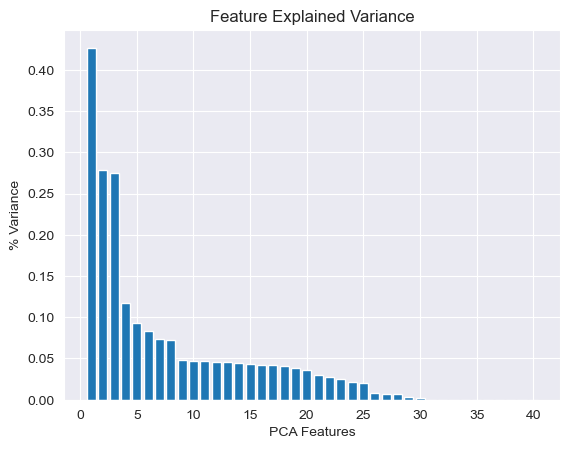

In [55]:
import matplotlib.pyplot as plt
plt.bar(
    range(1,len(pca.explained_variance_ratio_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Features')
plt.ylabel('% Variance')
plt.title('Feature Explained Variance')
plt.show()

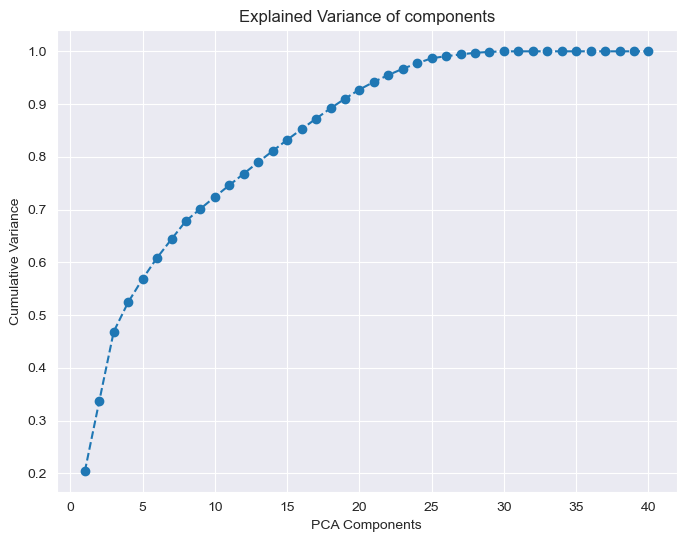

In [56]:
plt.figure(figsize=(8,6))
plt.plot(range(1,41),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')

plt.title('Explained Variance of components')
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Variance')
plt.show()

Text(0, 0.5, 'PCA 2')

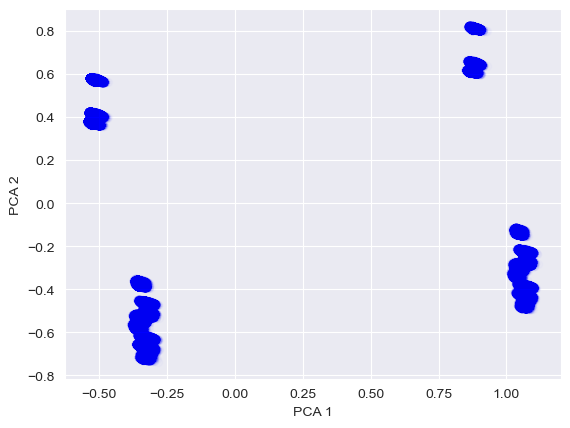

In [57]:
plt.scatter(data.iloc[:,0], data.iloc[:,1], alpha=0.01, color='blue')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [58]:
pca=PCA(n_components=15)
pca.fit(d_norm)
pca_features=pca.transform(d_norm)

In [62]:
wcss=[]
for i in range(1,22):
    k=KMeans(n_clusters=i,init='k-means++',random_state=40)
    k.fit(pca_features)
    wcss.append(k.inertia_)

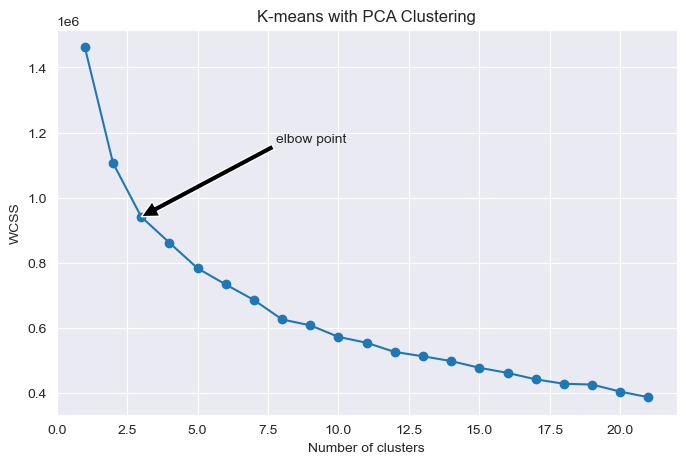

In [63]:
plt.figure(figsize=(8,5))
plt.plot(range(1,22),wcss,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.annotate('elbow point',(3,wcss[2]),arrowprops=dict(facecolor='black',shrink=0.001),
            horizontalalignment='left',verticalalignment='top',xytext=(7.8,1200000))
plt.show()

In [88]:
k=KMeans(n_clusters=3,init='random',random_state=42)
k=k.fit(pca_features)


In [89]:
df_kmeans=pd.concat([d.reset_index(drop=True),pd.DataFrame(pca_features)],axis=1)
df_kmeans['Clusters']=k.labels_

In [90]:
df_kmeans['Segment']=df_kmeans['Clusters'].map({0:'first',1:'second',2:'third',3:'fourth',4:'fifth',5:'sixth',6:'seventh',7:'eighth'})

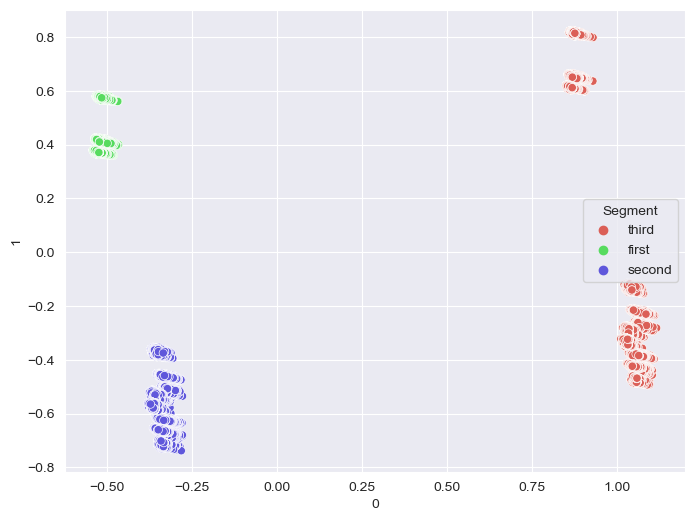

In [302]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

x=df_kmeans[0]
y=df_kmeans[1]
plt.figure(figsize=(8,6))
sns.scatterplot(x=x,y=y,hue=df_kmeans['Segment'],palette=sns.color_palette('hls',3))
plt.show()

In [198]:
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist

In [ ]:
# init centers
## while not converged
# update clusters membership
# update centers

In [303]:
def KMEANS (X_train,k):

    n=X_train.shape[0]
    p=X_train.shape[1]

    min_ = np.min(X_train, axis=0)
    max_ = np.max(X_train,axis=0)
    centers = X_train[np.random.choice(n,3,replace=False)]
    closest = np.zeros(n).astype(int)
    while True:
        prev_closest = closest.copy()
        #print(closest)
        distances=np.sqrt(np.sum(np.abs(X_train.reshape(n,1,p)-centers.reshape(1,3,p))**2,axis=2))
        closest = np.argmin(distances,axis=1)
        for i in range(k):
            centers[i,:] = X_train[closest==i].mean(axis=0)
        if all(closest == prev_closest):
            break
    return closest, centers


In [304]:
np.random.seed(12445)
closest,centers = KMEANS(pca_features,3)

In [305]:
df_kmeans['ScratchKMeans'] = closest
df_kmeans['ScratchKMeans'] = df_kmeans['ScratchKMeans'].map({0:'first',1:'third',2:'second'})

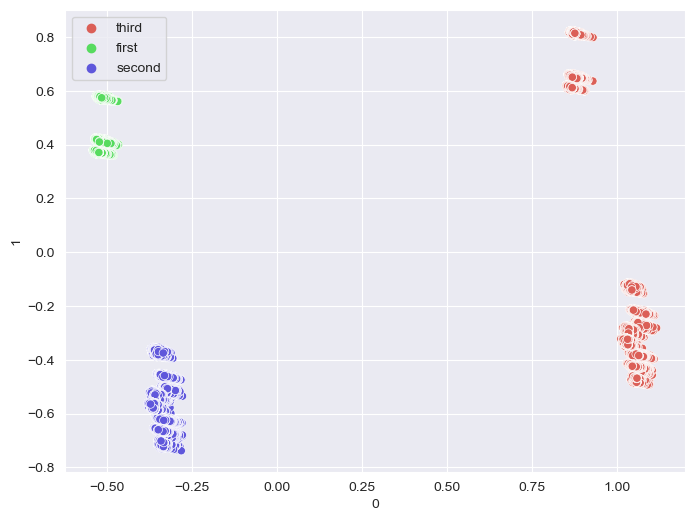

In [306]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_kmeans[0],y=df_kmeans[1],hue=df_kmeans['ScratchKMeans'],palette=sns.color_palette('hls',3))
plt.legend()
plt.show()